# Imports


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("..")

import os
import matplotlib.pyplot as plt
import torch

from model.llm import LLM
from model.tokenizer import Tokenizer, train_tokenizer

from helpers.dataset import NextTokenPredictionDataset
from helpers.trainer import train
from helpers.config import LLMConfig, TrainingConfig

# Set config

In [41]:
llm_config = LLMConfig(
    vocab_size=512,
    context_size=128,
    dim_emb=512,
    num_layers=8,
    num_heads=8
)

train_config = TrainingConfig(
    retrain_tokenizer=False,
    batch_size=64,
    learning_rate=1e-4,
    weight_decay=1e-2,
    max_steps=200,
    log_frequency=1
)

# Prepare tokenizer and dataset


In [31]:
input_file = "../data/shakespeare/alllines.txt"
output_path = "../data/shakespeare"

tokenizer_model_file = os.path.join(os.path.dirname(input_file), "tokenizer.model")
if not os.path.exists(tokenizer_model_file) or train_config.retrain_tokenizer:
    train_tokenizer(input_file, llm_config.vocab_size, tokenizer_model_file)

tokenizer = Tokenizer(tokenizer_model_file)

In [32]:
sentence = "The role of the tokenizer is to build a mapping between subwords and token indices"
print(tokenizer.sp.EncodeAsPieces(sentence))

assert tokenizer.decode(tokenizer.encode(sentence)) == sentence

['▁The', '▁r', 'o', 'le', '▁of', '▁the', '▁to', 'ke', 'n', 'i', 'z', 'er', '▁is', '▁to', '▁b', 'u', 'il', 'd', '▁a', '▁ma', 'pp', 'ing', '▁be', 't', 'w', 'e', 'en', '▁', 's', 'u', 'b', 'w', 'or', 'd', 's', '▁and', '▁to', 'ke', 'n', '▁in', 'd', 'ice', 's']


In [36]:
# This helper class allow to generate batches of inputs and targets where targets last element is the next token to predict
ds_train = NextTokenPredictionDataset(input_file, llm_config.context_size, tokenizer)

ds_train.get_batch(batch_size=1)

(tensor([[  9, 153,   5,  ..., 103, 127,  96]], dtype=torch.int32),
 tensor([[153,   5,   4,  ..., 127,  96, 272]]))

# Define model


In [50]:
model = LLM(
    vocab_size=llm_config.vocab_size,
    context_size=llm_config.context_size,
    dim_emb=llm_config.dim_emb,
    num_layers=llm_config.num_layers,
    attn_num_heads=llm_config.num_heads,
)

param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2

print(f"total params: {sum(p.numel() for p in model.parameters()):,d}")
print(f"learnable params: {sum(p.numel() for p in model.parameters() if p.requires_grad):,d}")
print(f"model size: {size_all_mb:.3f}MB")

print(model)

total params: 8,921,600
learnable params: 8,921,600
model size: 46.033MB
LLM(
  (token_embedding): Embedding(512, 512)
  (emb_dropout): Dropout(p=0.0, inplace=False)
  (transformer): Sequential(
    (0): TransformerBlock(
      (pos_encoding): CosinePositionalEncoding()
      (norm_1): RMSNorm()
      (multihead_attn): MultiHeadAttention(
        (projection_query): Linear(in_features=512, out_features=512, bias=False)
        (projection_key): Linear(in_features=512, out_features=512, bias=False)
        (projection_value): Linear(in_features=512, out_features=512, bias=False)
        (projection_out): Linear(in_features=512, out_features=512, bias=False)
      )
      (norm_2): RMSNorm()
      (feed_forward): FeedForward(
        (_layers): Sequential(
          (0): Linear(in_features=512, out_features=512, bias=False)
          (1): SwiGLU(
            (linear): Linear(in_features=512, out_features=1024, bias=True)
          )
          (2): Linear(in_features=512, out_features=512

# Train model


In [43]:
loss_history = train(
    model,
    ds_train,
    batch_size=train_config.batch_size,
    lr=train_config.learning_rate,
    max_steps=train_config.max_steps,
    weight_decay=train_config.weight_decay,
    log_every=train_config.log_frequency,
)

Text(0, 0.5, 'cross entropy loss')

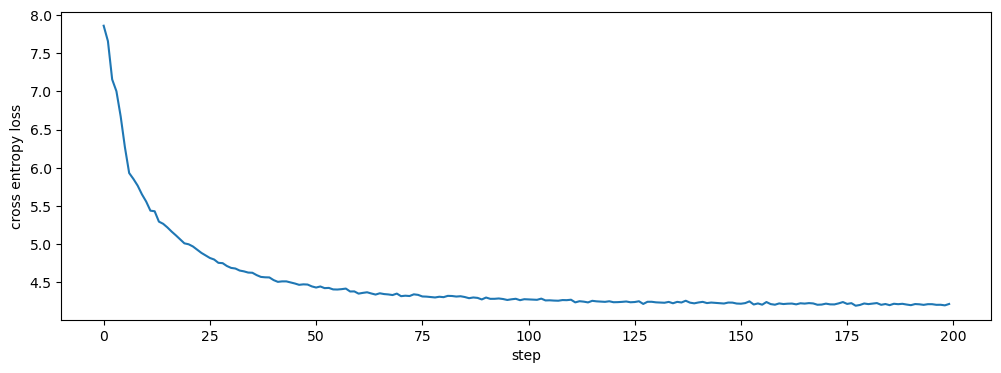

In [44]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(range(len(loss_history["train_loss"])), loss_history["train_loss"])
ax.set_xlabel("step")
ax.set_ylabel("cross entropy loss")

# Play around

In [45]:
# empty prompt to generate random stuff
prompt = torch.zeros((1, llm_config.context_size), dtype=torch.int32)
out = model.generate(prompt, max_seq_len=50)
tokenizer.decode(out)

"ose baned fair kind' Pamb scivingarvne on his s Ha pered fellowzen, brother of this getedise Lan hy, ga, and"

In [46]:
prompt = tokenizer.encode("I took an arrow to the knee, ", beg_of_string=True, pad_seq=True, seq_len=llm_config.context_size).view(1, -1)
out = model.generate(prompt, max_seq_len=50)
tokenizer.decode(out)

"I took an arrow to the knee, s st me voment and or the e canformed withy. O, Awainsk! wat, full, CAF showed.st, I! I'll s so"